<a href="https://colab.research.google.com/github/tada20001/NLP_2023/blob/main/CH9_04_%EB%84%A4%EA%B1%B0%ED%8B%B0%EB%B8%8C_%EC%83%98%ED%94%8C%EB%A7%81%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_Word2Vec_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 네거티브 샘플링(Nagative sampling)

-----------------
Word2Vec의 출력층에는 **소프트맥스 함수를 지닌 단어 집합크기의 벡터와 실제 값인 원-핫 벡터와의 오차**를 구하고 이로부터 **임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터값을 업데이트**함

만약 단어집합의 크기가 수만 이상에 달한다면 이 작업은 굉장히 리소스가 필요함. 

Word2Vec은 역전파과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 만약 현재 집중하고 있는 중심단어와 주변단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적임

네거티브 샘플링은 Word2Vec이 학습과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법임

즉, 의미없는 무작위로 선택된 주변단어가 아니라 의미있는 단어만을 사용한다는 개념임

하나의 중심단어에 대해 전체 단어집합보다 훨씬 작은 단어집합을 만들어놓고 마지막 단계를 이진분류로 변환하는 문제임

주변단어를 긍정, 랜덤으로 샘플링도니 단어들을 부정으로 레이블링하는 이진분류 데이터셋임


### 2. 네거티브 샘플링 skip-gram
--------------------------

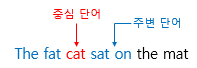




skip-gram은 중심단어로부터 주변단어를 예측하는 모델임. 하지만 네거티브 샘플링을 사용하는 skip-gram(SGNS)는 다른 방법을 채택함. SGNS는 중심단어와 주변단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃관계인지 그 확률을 예측함
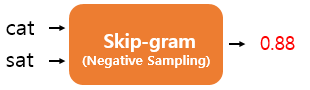




기존의 skip-gram 데이터셋을 SGNS 데이터셋으로 바꾸는 과정은 다음과 같음

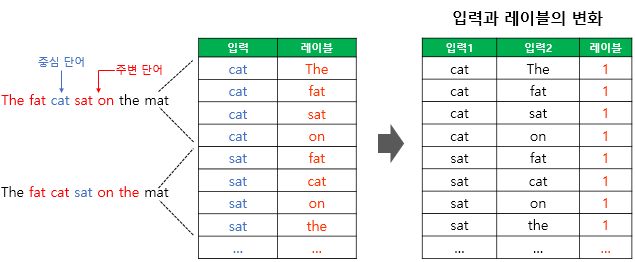

기존의 skip-gram 데이터셋에서 중심단어와 주변단어를 각각 입력1, 입력2에 두고, 이 둘이 실제 윈도우 크기내에서 이웃관계이면 1로 레이블함

레이블 0에 대한 샘플은 다음과 같이 준비함

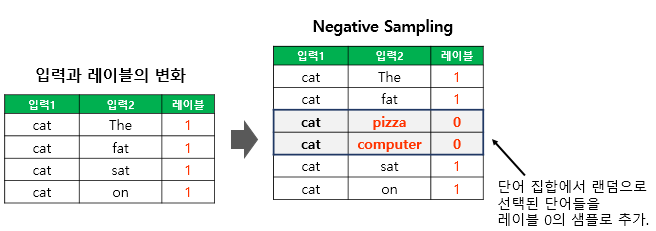

실제 입력1과 주변단어 관계가 아닌 단어들을 입력2로 삼기 위해서는 단어집합에서 랜덤으로 선택한 단어들을 입력2로 하고, 레이블을 0으로 함

이렇게 준비된 데이터셋은 입력1, 입력2 두개의 임베딩 테이블을 준비함. 이 테이블은 훈련데이터의 단어집합 크기를 가지므로 크기가 같음

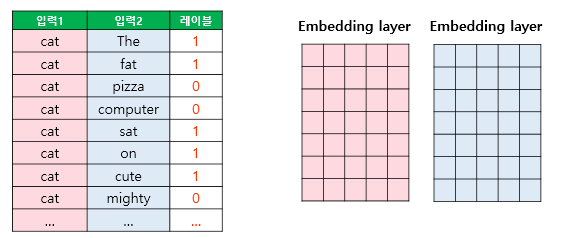


두 테이블 중 하나는 입력1인 중심단어의 테이블 룩업을 위한 임베딩 테이블이고, 입력2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블임 각 단어는 각 임베딩 테이블을 테이블 룩업하여 임베딩 벡터로 변환됨

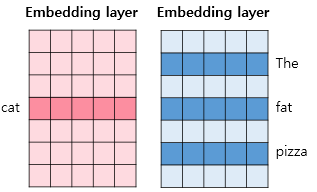

각 임베딩 테이블을 통해 테이블 룩업하여 임베딩 벡터로 변환되었다면, 그 후의 연산은 매우 간단함

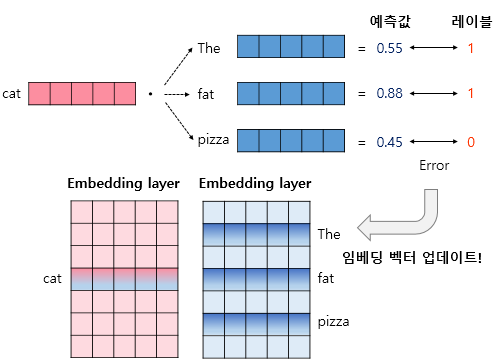

중심단어와 주변단어의 내적값을 이 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파하여 중심단어와 주변단어의 임베딩 벡터값을 업데이트함

학습후에는 좌측의 임베딩 행렬을 임베딩 벡터로 사용할 수도 있고, 두 행렬을 더한 후 사용하거나 두행렬을 연결해서 사용할 수 있음

### 3. 20 newsgroups data 전처리

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

여기에서는 하나의 샘플에 최소 단어 2개는 있어야 함. 그래야만 중심단어와 주변단어로 구성할 수 있음. 이에 대해 전처리를 실시하여 2개 이상 없는 샘플은 제거함

In [3]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

총 샘플 수는 11,314개로 전처리를 진행함. 불필요한 토큰을 제거하고 소문자화 진행

In [4]:
documents[0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [15]:
news_df = pd.DataFrame({'documents': documents})
news_df.head()

,documents
0,Well i'm not sure about the story nad it did s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,Although I realize that principle is not one o...
3,Notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ..."


In [17]:
# 특수문자 제거
news_df['clean_doc'] = news_df['documents'].str.replace("[^a-zA-Z]", ' ')  # 특수문자는 빈값으로 대체
# 길이가 3이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-17-0e66eb5b7d80>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['documents'].str.replace("[^a-zA-Z]", ' ')  # 특수문자는 빈값으로 대체


In [18]:
news_df.shape

(11314, 2)

In [19]:
# null 값 확인
news_df.isnull().sum()

documents    0
clean_doc    0
dtype: int64

In [20]:
# empty 값 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().sum()

documents    218
clean_doc    319
dtype: int64

In [21]:
# empty --> null --> null 제거
news_df.dropna(inplace=True)
news_df.shape

(10995, 2)

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# 불용어 제거
stop_words = stopwords.words('english')

tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [26]:
print(tokenized_doc[0])

['well', 'sure', 'story', 'seem', 'biased', 'disagree', 'statement', 'media', 'ruin', 'israels', 'reputation', 'rediculous', 'media', 'israeli', 'media', 'world', 'lived', 'europe', 'realize', 'incidences', 'described', 'letter', 'occured', 'media', 'whole', 'seem', 'ignore', 'subsidizing', 'israels', 'existance', 'europeans', 'least', 'degree', 'think', 'might', 'reason', 'report', 'clearly', 'atrocities', 'shame', 'austria', 'daily', 'reports', 'inhuman', 'acts', 'commited', 'israeli', 'soldiers', 'blessing', 'received', 'government', 'makes', 'holocaust', 'guilt', 'away', 'look', 'jews', 'treating', 'races', 'power', 'unfortunate']


In [28]:
news_df['documents'][0]

"Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"

In [29]:
## 불용어 제거 후 다시 단어의 수 확인. 1개 이하인 경우는 모두 찾아 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) < 2]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
len(tokenized_doc)

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


10940

In [30]:
# 단어집합을 생성하고 정수 인코딩 수행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {index : word for word, index in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [32]:
print(encoded[0])
print(len(encoded[0]))

[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295]
61


In [33]:
len(tokenized_doc[0])

61

In [34]:
# 단어집합 크기 설정
vocab_size = len(word2idx) + 1
vocab_size

64277

### 4. 네거티브 샘플링 데이터셋 구현
--------------------
지금까지 토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 진행함

다음으로 네거티브 샘플링을 위해, 케라스에서 제공하는 전처리 도구인 skigrams을 사용함

시간이 많이 소요되므로 상위 10개 뉴스그룹 샘플만 수행

In [35]:
from tensorflow.keras.preprocessing.sequence import skipgrams

In [36]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10] ]

결과를 확인하면 다음과 같음


In [40]:
# 첫번째 샘플인 skip_grams[0] 내에 skipgrams로 형성된 데이터셋 확인
print(skip_grams[0])
print(len(skip_grams[0]))
print(len(skip_grams[0][0])) # 2 x 2220

([[149, 42805], [4520, 55887], [702, 32496], [1495, 9], [6, 87], [4406, 4865], [4865, 35208], [603, 44512], [10669, 25132], [4294, 20294], [13686, 54235], [702, 702], [702, 20294], [15227, 702], [207, 28367], [70, 984], [10669, 12308], [1530, 4520], [4520, 36590], [217, 6080], [6, 4865], [442, 19720], [4294, 4865], [70, 702], [1148, 7626], [149, 21512], [702, 59960], [9470, 3278], [4295, 5186], [66, 10669], [52, 779], [661, 7752], [2669, 37939], [4295, 29462], [661, 30215], [1036, 1979], [4989, 57540], [3278, 22696], [207, 702], [1148, 1036], [1530, 43615], [661, 31773], [702, 52353], [6066, 25133], [4294, 13686], [4520, 217], [702, 702], [4294, 1979], [4865, 24332], [1148, 54977], [4520, 705], [59, 603], [149, 1102], [634, 5129], [13686, 59829], [87, 2568], [702, 20285], [1148, 21234], [1530, 1920], [1920, 35253], [1148, 10455], [15227, 442], [7837, 23697], [634, 41852], [59, 702], [661, 442], [702, 45652], [20294, 217], [702, 20827], [705, 18198], [4865, 4406], [9470, 474], [1036, 35

In [41]:
print(skip_grams[0][0])
print(skip_grams[0][1])

[[149, 42805], [4520, 55887], [702, 32496], [1495, 9], [6, 87], [4406, 4865], [4865, 35208], [603, 44512], [10669, 25132], [4294, 20294], [13686, 54235], [702, 702], [702, 20294], [15227, 702], [207, 28367], [70, 984], [10669, 12308], [1530, 4520], [4520, 36590], [217, 6080], [6, 4865], [442, 19720], [4294, 4865], [70, 702], [1148, 7626], [149, 21512], [702, 59960], [9470, 3278], [4295, 5186], [66, 10669], [52, 779], [661, 7752], [2669, 37939], [4295, 29462], [661, 30215], [1036, 1979], [4989, 57540], [3278, 22696], [207, 702], [1148, 1036], [1530, 43615], [661, 31773], [702, 52353], [6066, 25133], [4294, 13686], [4520, 217], [702, 702], [4294, 1979], [4865, 24332], [1148, 54977], [4520, 705], [59, 603], [149, 1102], [634, 5129], [13686, 59829], [87, 2568], [702, 20285], [1148, 21234], [1530, 1920], [1920, 35253], [1148, 10455], [15227, 442], [7837, 23697], [634, 41852], [59, 702], [661, 442], [702, 45652], [20294, 217], [702, 20827], [705, 18198], [4865, 4406], [9470, 474], [1036, 351

In [43]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(10):
  print("({:s} ({:d}), {:s} ({:d})) --> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0], idx2word[pairs[i][1]], pairs[i][1], labels[i]
  ))

(reason (149), seqitur (42805)) --> 0
(europeans (4520), defecate (55887)) --> 0
(media (702), prostanoid (32496)) --> 0
(disagree (1495), well (9)) --> 1
(think (6), least (87)) --> 1
(atrocities (4406), existance (4865)) --> 1
(existance (4865), apocryphal (35208)) --> 0
(story (603), tragedies (44512)) --> 0
(blessing (10669), dione (25132)) --> 0
(occured (4294), incidences (20294)) --> 1


위의 과정을 각 뉴스그룹 샘플에 대해 수행함

In [44]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 5. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [45]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

하이퍼파라미터인 임베딩 벡터 차원은 100으로 정하고, 두개의 임베딩 층을 추가함

In [48]:
embedding_dim = 100

# 중심단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

각 임베딩 테이블은 중심단어와 주변단어 각각을 위한 임베딩 테이블이며, 각 단어는 임베딩 테이블을 거쳐 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해 시그모이드 함수를 활성화 함수로 설정하여 최종 예측값을 얻음

In [49]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])  # 두 임베딩 테이블 내적적
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)  # 1 또는 0인지 예측


In [50]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       6427700     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       6427700     ['input_4[0][0]']                
                                                                                              

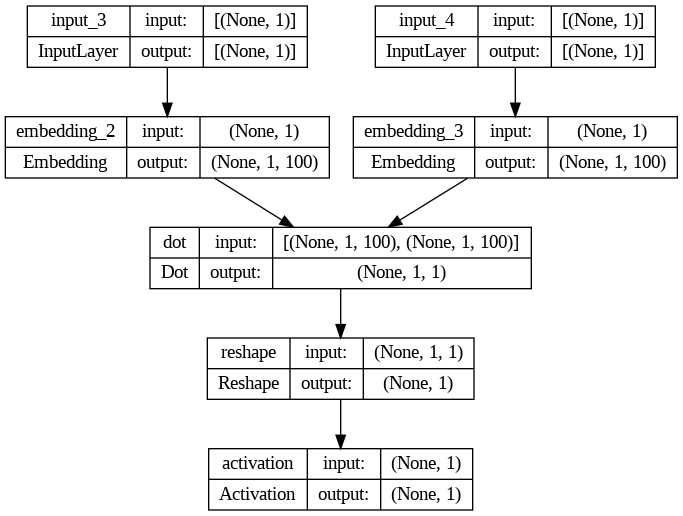

In [51]:
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [52]:
# 모델 학습은 5 에포크 수행

for epoch in range(1, 6):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')  # pairs[0]
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32') # pairs[1]
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)
  print('Epoch : ', epoch, 'Loss : ', loss)

Epoch :  1 Loss :  4626.4606096334755
Epoch :  2 Loss :  3677.286948990077
Epoch :  3 Loss :  3523.205801092088
Epoch :  4 Loss :  3313.686291223392
Epoch :  5 Loss :  3086.739008070901


### 6. 결과 확인하기
-------
학습된 임베딩 벡터들을 vector.txt에 저장한 후, 이를 다시 로드하여 단어 벡터간 유사도를 구함

In [53]:
import gensim

In [57]:
f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [58]:
# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [59]:
# 테스트
w2v.most_similar(positive=['soliders'])

[('pursuade', 0.756031334400177),
 ('actaual', 0.7558411955833435),
 ('codification', 0.7558375597000122),
 ('nguen', 0.7533082962036133),
 ('multispin', 0.7510679960250854),
 ('programer', 0.7463830709457397),
 ('necesarily', 0.7460240125656128),
 ('litte', 0.7436625957489014),
 ('synchronize', 0.7435529232025146),
 ('achived', 0.7434056401252747)]

In [60]:
w2v.most_similar(positive=['doctor'])

[('pain', 0.6555050611495972),
 ('chronic', 0.5714582800865173),
 ('cure', 0.5590659379959106),
 ('cardiac', 0.5561159253120422),
 ('cultures', 0.5545979142189026),
 ('allergic', 0.5519773364067078),
 ('disease', 0.5491855144500732),
 ('mess', 0.5217698812484741),
 ('chemotherapy', 0.5208103656768799),
 ('lesson', 0.519006609916687)]

In [61]:
w2v.most_similar(positive=['police'])

[('constitution', 0.6298995614051819),
 ('regulated', 0.5797895789146423),
 ('burglary', 0.5771236419677734),
 ('spain', 0.5698602199554443),
 ('civil', 0.568687915802002),
 ('defend', 0.5659030079841614),
 ('allegedly', 0.56501704454422),
 ('intent', 0.5630217790603638),
 ('grounds', 0.5600638389587402),
 ('controlling', 0.5594750046730042)]

In [62]:
w2v.most_similar(positive=['knife'])

[('suffered', 0.6545814275741577),
 ('shalala', 0.6456278562545776),
 ('deserved', 0.6316908597946167),
 ('immigrants', 0.628429114818573),
 ('reforms', 0.621526837348938),
 ('blinded', 0.6203305721282959),
 ('appeared', 0.6168599724769592),
 ('thirty', 0.6167877912521362),
 ('wars', 0.614570140838623),
 ('arguably', 0.6115436553955078)]

In [63]:
w2v.most_similar(positive=['engine'])

[('tires', 0.6160838007926941),
 ('valve', 0.5944927334785461),
 ('clutch', 0.590599775314331),
 ('throttle', 0.5691445469856262),
 ('brakes', 0.5668171644210815),
 ('rebuilt', 0.5458862781524658),
 ('piston', 0.5428356528282166),
 ('combustion', 0.5283178091049194),
 ('gear', 0.5210062265396118),
 ('tune', 0.5170101523399353)]